# Problem Set #3: Models of Reinforcement Learning
**DUE 3 March 2022 - NEU 502A**

**Submission Directions:** Prior to submitting, clear you kernel and run through all your cells in order so figures and variables are accurately recorded. Only include cells with necessary code or answers, do not include cells used for troubleshooting. Email this notebook with your last name in the filename to Eric (ewh3@princeton.edu) by 5pm.

Previously we aimed to get a sense of how a system could extract the hidden structure in sensory stimuli (i.e. natural scenes). We implemented unsupervised learning in the form of Hebbian rules to this end. Our model was shown a set of images with no final goal specified, nor expectations with which to compare its performance throughout learning. Now we are interested in how a system can learn to reach a goal through interactions with its environment. Specifically, we are interested in modelling how a system can learn to maximize rewards or minimize penalties.

Think about an infant as it moves and looks around. Sometimes the parent will guide its actions, yet it may not be the case at all times. Even when alone, there is learning taking place. There is a sensory-motor connection with the environment, where the infant gains knowledge about cause and effect. Throughout our experience, we are aware of how our surroundings respond to our actions. Thus, we actively seek to influence this relationship, and learn from it to maximize positive interactions and minimize negative ones.
    
Reinforcement learning models are about solving problems to maximize a quantification of reward. The models use goal-directed learning to solve closed-loop¬ problems. This can be seen below where present actions influence the environment, in turn changing the circumstances in which the learning system will act in the future towards the same goal. In RL, we hope to discover the actions that increase chances of rewards within specific states in the environment.

<img src="model.png" width="350">  

Let’s call the learning system an agent interacting with an environment to achieve a goal. This agent must be able to sense the state of the environment either fully or partially, and its actions must be able to change this said state. Here is an example:
> “Think about preparing breakfast. Closely examined, this activity reveals a complex web of conditional behaviors with goal-subgoal relationships: walking to the cupboard, opening it, selecting a cereal box, then reaching for, grasping, and retrieving the box. Another set of interactive sequences are required to obtain a bowl, spoon, and milk jug. Each step involves a series of eye movements to obtain information and to guide them. Rapid judgments are continually made about how to carry the objects or whether it is better to ferry some of them to the dining table before obtaining others. Each step is guided by goals, such as grasping a spoon or getting to the refrigerator, and is in service of other goals, such as having the spoon to eat with once the cereal is prepared and ultimately obtaining nourishment. Whether you are aware of it or not, you are accessing information about the state of your body that determines nutritional needs, level of hunger, and food preferences.”

At each junction, there is a state-action pair. Some of them fall under sub-goals, while others could ultimately be a state where there is a high chance of reward, fulfilling the goal of feeding. To be able to model this process, we have to break it down into its interacting components: 
- The agent has a policy, the map between perceived states and the actions taken. We can think of it as a set of stimulus-response rules or associations that determine behavior given a state and a goal within the environment. It can be implemented through the probabilities of taking specific actions given a state. 
- This set of rules should help to maximize the reward signal, be it at the short or long term. 
- The signal is evaluated through a value function, which provides a measure of the expected rewards that can be obtained moving forward from a specific state. Grabbing a bowl might not feed you immediately, yet it has high value as it will lead you to a state in which you can feed yourself some cereal without spilling milk all over the table. Would grabbing a shallow dish instead of a bowl have the same value, within the confines of the above example? Actions are taken based on these value judgements. 
- The agent could have the ability for foresight and planning if it has a model of the environment. This means it can have a model of how the environment reacts to its behavior, from which to base its strategies and adjustments.

At each decision, the agent has a choice to either exploit the actions it has already tested to be effective, or it can explore the action-state space to find new routes to optimal rewards. Exploration is risky, yet under some circumstances it will pay off in the long run. Finding the balance between the two would be the optimal solution in uncertain environments. Different methods can be employed to deal with this duality:
- On-policy methods improve the policy that is used to make decisions. This policy is generally soft (probabilistic), as $P(s∈S,a∈A│s)>0$, where $S$ is the possible states and $A|s$ is the possible actions given a state. The probability is gradually shifted to a deterministic optimal policy with each update. For example, $\epsilon-greedy$ policies choose an action that has maximal expected value most of the time (with probability 1 – a small number $\epsilon$). However, with probability $\epsilon$ they choose an action at random. The method is trying to learn values based on subsequent optimal behavior, yet it has to behave non-optimally (choosing random actions) in order to explore and find the optimal actions. This means the agent has to learn about the optimal policy while behaving according to an exploratory policy. On-policy can be thought of as a compromise, where values are learned for a near optimal policy that still explores. 
- Another approach is to use two policies, a target policy and a behavior policy. The first one is modified based on the information that is collected through the behaviors generated by the second. This approach is termed off-policy, as learning occurs based on behaviors generated off the policy being developed. The benefit here is that the target policy can be deterministic (i.e. greedy), while the behavior-policy can continue to explore without limits.

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.special import logsumexp,softmax
from scipy.stats import norm

import seaborn as sns
import pandas as pd
import random

%matplotlib inline
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

### PART I – Fitting RL models to data

**A :: Run the *sequential/sequential.m* matlab task on yourself.**

First, we need to acquire some data. You are the agent this time around. For this you need Matlab with Psychtoolbox installed. The code that runs the experiment has been tested on Mac. Some adjustments may be needed so that it runs smoothly on Windows. (If you are running Windows, we recommend you borrow a Mac to do the experiment, or use the Princeton Mac cluster). If you are unable to run the experiment, please inform the instructor. 

Steps to run:

1.	Unzip the attached directory “/sequential”

2.	Run “sequential/tutorial.m” which will explain the decision-making task.

3.	Run the task itself: “sequential/sequential.m” - this is a challenging task, so you might want to sequester yourself to a quiet room where you can concentrate. The task will take about 20 minutes. Try to do your best as you will compete to see who wins the most coins! 

    The data from your experiment can be found under the directory from which you ran the task, in a file called “Subj##-date-time.mat” where ## is the subject number you gave yourself, and the date and time are those at which you finished the task. (Please Email your data to the A.I. when you are done). The data is structured as follows:
•	choice1 - your choices at the first level (1 or 2)
•	choice2 - your choices at the second level (1 or 2)
•	state - which second level game you were offered on this trial (choice1 = 1 at the first level (S1) leads to S2 in approximately 70% of the trials; choice1 = 2 leads to S3 in approximately 70% of the trials)
•	money - did you get a reward on each trial or not (1 or 0)

    Note that missed trials will have a 0 in the choice; trials can be missed either at the first or second level. When you write your code (latter on), make sure to deal separately with missed trials as this is a common source of discrepancies while fitting the models. Below is a schematic of the task structure:


<img src="task.png" width="400">

|       | $A_1$     | $A_2$     |
|:-----:|:---------:|:---------:|
| $S_1$ | $Q_{S1,A1}$ | $Q_{S1,A2}$ |
| $S_2$ | $Q_{S2,A1}$ | $Q_{S2,A2}$ |
| $S_3$ | $Q_{S3,A1}$ | $Q_{S3,A2}$ |


The schematic might not map to the colors used in the actual task.  S1 refers to the state at the top (first) level, where you will be shown two distinct symbols. You will have to choose one of the two (represented by action | state in the schematic). One of the symbols, let’s say A1|S1 will have 70% chance of transferring you to S2 (one of the possible states at the bottom level), and a 30% chance of getting you to S3. This is represented by the thickness of the arrows. The same goes for the symbol represented by A2|S1, yet the chances are inverted. At the bottom (second) level, you can be at either of two distinct states (S2 or S3). Once again you will need to choose between two symbols at each state, with gradually drifting chances of getting a coin once a decision is made. For example, symbol A1|S2 might start with higher chances than A2|S2. These will change gradually with time and at some point, the chances might be reversed. There is no implicit relationship between what happens in S2 and S3. You will have to learn, with each experience, which choices lead you to better rewards.

In [121]:
def load_data(fn):
    "Loading in matlab data structures for 2-step RL task (Daw et al., 2011)"
    d = loadmat(fn)
    
    def fix_vector(arr):
        "Making the array signed for subtraction to work, and resizing to 2D matrix and last dim size is 1"
        return arr.astype(np.int8).squeeze().reshape((-1,1))
    
    #variables for fitting:
    choice1 = fix_vector(d["choice1"])
    choice2 = fix_vector(d["choice2"])
    state = fix_vector(d["state"])
    money = fix_vector(d["money"])
    
    #adjust to start 0-indexing
    choice1 -= 1
    choice2 -= 1
    state -= 1
    
    #adjust to 1D vectors
    return choice1.flatten(), choice2.flatten(), state.flatten(), money.flatten()

#load given sample data
c1, c2, s, r = load_data('data.mat')

#load collected class data. given to you by your AI


**B :: Write down the update (learning) equations for two different models:**

**b1.** At the bottom level, learning can be modeled with $Q$-learning or Rescorla-Wagner learning (as there is no future state). Note that these are identical if you treat each option as an action (in $Q$ learning) or as a state (the state of the chosen stimulus; in Rescorla-Wagner). Write down the equation for either one.

>**Rescorla-Wagner**: $V \leftarrow V + \alpha(r-V)$
>
>or
>
>**Q-Learning**: $Q(s,a) \leftarrow Q(s,a) + \alpha (r + max_a Q(s',a)-Q(s,a))$

where $\alpha$ is learning rate

**b2.** At the top level, you can learn in several different ways. We will consider two:

**b2a.** Model-free learning:

> **b2ai.** Write down the Temporal Difference (TD) update rule for the first level. Can you think of a way to improve upon this learning rule, without requiring a model of the environment? For instance, how can you take into account the result of the choice at the second level here? 

>>**TD(0)**: $V(s) \leftarrow V(s) + \alpha (r + V(s')-V(s))$
>>
>>**Answer:** We can add a discount factor term ($\gamma$), discouting the value of future rewards : now the prediction error will be: $r + \gamma V(s')-V(s)$

> **b2aii.** One way to make learning more efficient is to use TD($\lambda$) instead of TD(0) learning. In this case, there is an additional memory variable associated with each state, its “eligibility trace". You can think of it as a “memory" that a particular state has been visited, which decays (for instance, exponentially) over time. Every time a state is visited, its eligibility trace becomes 1; at every subsequent time-point the eligibility trace is multiplied by a factor $0 < \lambda \leq 1$. At the end of a trial or episode, all eligibility traces become 0. 
>
> All states are updated according to *learning rate $\cdot$ prediction error $\cdot$ eligibility trace*. This will automatically update all the states visited in this episode (i.e. all the states `eligible' for updating), doing so for the most recently visited states to a greater extent. Write the updated equation.


>>**TD($\lambda$)**: $V(s) \leftarrow V(s) + \alpha E(s) (r + V(s')-V(s))$
>> where the eligibility trace vector (E) is initialized to zero at the beginning of the episode, adn updates at each time step according to
$E(s') = \lambda E(s)$.

**b2b.** Model-based learning:

> **b2bi.** Assume that the transition model (i.e. the probabilities of going from $S1$ to $S2$ or $S3$ given choice1) is known from the start, while the reward model is not known. How can you use the transitions and the learned values at the bottom level to plan and make choices at the top level?

>>**Answer:** we can consider the probabilities of transitioning from S1 to S2 or S3 while making the top-level decision. 

>**b2bii.** How would you implement it?

>>**Answer:** $$Q(s, a) = p(s'_2|s, a)max_{a}Q(s'_2,a) + p(s'_3|s, a)max_{a}Q(s'_3,a)$$

>> where we know that 
$$ p(s_2 | s_1, a_1) = p(s_3 | s_1, a_2) = 0.7 $$

$$ p(s_2 | s_1, a_2) = p(s_3 | s_1, a_1) = 0.3 $$

**b3.** How many parameters do each of these models have?

>**RW:** $\alpha$ - learning rate
>
>**Q-Learning:** $\alpha$ - learning rate 
>
>**TD(0):** $\alpha$ - learning rate
>
>**TD($\lambda$):**  $\alpha$ - learning rate and $\lambda$ - eligibity trace

Comments:
 - If we choose to use a discount factor $\gamma$, it will be an additional parameter to fit. 
 - Most models will use a choice kernel that includes an inverse temporature term $\beta$, increasing the parameter count.

**C :: Implement and fit the above models.** Below, we have provided a template function rl_nll() for computing the negative log-likelihood (LL) of the data and code blocks with templates computing LL given parameters and for fitting the models using Scipy's minimize(). You will refer to these templates to complete later questions.

In [122]:
# # example of partial rl_nll() function

# def rl_nll(eta, beta, lambd, state, choice1, choice2, money):
#     """
#     output: LL - the negative log likelihood of the data
#     input:
#         eta     - learning rate
#         beta    - softmax inverse temperature
#         lambda  - eligibility trace decay rate (set to 0 to get TD(0) without eligibility traces)
#         state   - state, 0 is the top level, 1 and 2 are the bottom level
#         choice1 - the choice at the top level -- 0 or 1 (-1 for missed trials)
#         choice2 - the choice at the bottom level -- 0 or 1 (-1 for missed trials)
#         money   - amount won (1 or 0)
    
#     """
    
#     n_states = 3
#     n_actions = 2
#     n_trials = len(choice1)
    
#     Q = np.zeros([n_states, n_actions]) # initialize Q values to 0
#     LL = 0.0 # initialize log-likelihood
    
#     # loop through trials
#     for t in range(n_trials):
        
#         # initialize eligibility trace
#         E = np.zeros([n_states, n_actions])
#         S = 0 # current state, first we are in the top level 
        
#         # stop if trial was missed 
#         if choice1[t] == -1:
#             continue
                
#         # first level choice likelihood (compute likelihood of choice at first state s)
#         # note: this comment uses Matlab notation, copied from rllik.m 
#         # p(1) = exp(b(q(s, a)/sum(exp(b(q(s, all_actions))))
#         # p(2) = 1 - p(1) 
#         # p(chosen) = p(x) either 1 or 2 - look at data & compare
#         # LL = LL + log(p(chosen))
#         LL += # LL is log-likelihood of choices, fill something in here 

#         # learning at first level 
#         E[S, choice1[t]] = 1 # eligibility trace updated
#         PE = # prediction error, fill in something here
        
#         Q[S, choice1[t]] = # fill in something here to update Q values
        
#         # second level choice likelihood
#         S = state[t] 
        
#         # stop if trial was missed
#         if choice2[t] == -1:
#             continue
            
#         # update LL with second choice log likelihood
#         LL += # fill in something here
        
#         # learning at second level
        
#         # update eligibility trace
#         E = lambd * E # first decay all eligbility traces
#         E[S, choice2[t]] = 1 # then update current eligilibity trace
        
#         PE = # fill in something here
        
#         # update Q values 
#         Q # fill in something here
        
#         # Is this model-based or model-free? Do you have to update first level again?
#         # if you need to update first level again, do so here. 
        
#     # we are minimizing this function, so use negative LL
#     LL *= -1.0
    
#     return LL

In [123]:
# # example of computing log-likelihood given parameters eta, beta, and lambd 
# # note that this will not run until rl_nll is completed

# # initialize parameters
# eta = 0.5
# beta = 0.5
# lambd = 0.5
# params = np.array([eta,beta,lambd])

# print("model-free LL of given sample data:", rl_nll(params, s, c1, c2, m, model_based=False))

In [124]:
# # example of constrained optimization of parameters 
# # note that this will not run until rl_nll is completed

# # initial condition
# x0 = np.random.uniform(size=[3,])

# # boundaries for eta, beta, and lambd respectively
# eta_bnd = (LB, UB)
# beta_bnd = (LB, UB)
# lambd_bnd = (LB, UB)
# bnds = (eta_bnd, beta_bnd, lambd_bnd)

# # optimize by minimizing the negative log likelihood
# # xo is initial condition of parameters
# # optimization method is L-BFGS-B
# # bounds are the lower and upper bounds
# # args are arguments to the function we are optimizing after the first argument, which is the parameters
# res = minimize(rl_nll, x0, method='L-BFGS-B', bounds=bnds, 
#                args=(state, choice1, choice2, money))

# # print results
# print("Params [eta, beta, lambda] = ",res.x) # the final setting of the parameters
# print("Negative log likelihood = ", res.fun) # the final negative log-likelihood value

**c1.** Using the template above, modify the log-likelihood function rl_nll() so that it implements model-free and model-based learning by including the input: model_based=True or model_based=False.

In [125]:
def rl_nll_mf(params, state, choice1, choice2, money, model_based=False):
    
    """
    output: LL - the negative log likelihood of the data
    input:
        eta     - learning rate
        beta    - softmax inverse temperature
        lambda  - eligibility trace decay rate (set to 0 to get TD(0) without eligibility traces)
        state   - state, 0 is the top level, 1 and 2 are the bottom level
        choice1 - the choice at the top level -- 0 or 1 (-1 for missed trials)
        choice2 - the choice at the bottom level -- 0 or 1 (-1 for missed trials)
        money   - amount won (1 or 0)
    returns:
        LL      - value of the LL of the data given the params
    """
    
    eta, beta, lambd = params
    n_states = 3
    n_actions = 2
    n_trials = len(choice1)
    
    Q = np.zeros([n_states, n_actions]) # initialize Q values to 0

    LL = 0.0 # initialize log-likelihood
    S_0 = 0 # first state is always 0
    
    # loop through trials
    for t in range(n_trials):
        
        # stop if trial was missed
        if (choice2[t] == -1) or (choice1[t] == -1):
            continue
            
        # initialize eligibility trace
        E = np.zeros([n_states, n_actions])
        S_tag = state[t] # current state, first we are in the top level 
        
                
        # first level choice likelihood (compute likelihood of choice at first state s)
        # note: this comment uses Matlab notation, copied from rllik.m 
        # p(1) = exp(b(q(s, a)/sum(exp(b(q(s, all_actions))))
        # p(2) = 1 - p(1) 
        # p(chosen) = p(x) either 1 or 2 - look at data & compare
        # LL = LL + log(p(chosen))
        
        p_choice1 = softmax(beta*Q[S_0])[choice1[t]]            
        LL += np.log(p_choice1)
        
        # learning at first level 
        # Q1(a_i) +=  eta * ( Q2[s_j, a_k] -  Q1(a_i) )

        E[S_0, choice1[t]] = 1# eligibility trace updated
        PE =  0 + Q[S_tag, choice2[t]] - Q[S_0, choice1[t]]  # fill in something here
        
        # update Q values 
        Q += eta*PE*E 
        
        # update LL with second choice log likelihood
        p_choice2 = softmax(beta*Q[S_tag])[choice2[t]]
        LL += np.log(p_choice2)
        
        # learning at second level
        #Q2(s_j, a_k) +=  eta * (r(s_j, a_k) - Q2(s_j, a_k))
        # update eligibility trace
        E = lambd * E # first decay all eligbility traces
        E[S_tag, choice2[t]] = 1 # then update current eligilibity trace
        
        PE =  money[t] + 0 - Q[S_tag, choice2[t]] # fill in something here
        
        # update Q values 
        Q += eta*PE*E # fill in something here
        
        # Is this model-based or model-free? Do you have to update first level again?
        # if you need to update first level again, do so here. 
        
    # we are minimizing this function, so use negative LL
    LL *= -1.0
    
    return LL

In [126]:
# example of constrained optimization of parameters 
# note that this will not run until rl_nll is completed

# initial condition
x0 = np.random.uniform(size=[3,])
x0 = norm.cdf(x0)
x0[1]*=10

# boundaries for eta, beta, and lambd respectively
eta_bnd = (0, 1)
beta_bnd = (0, 10)
lambd_bnd = (0, 1)

bnds = (eta_bnd, beta_bnd, lambd_bnd)
# optimize by minimizing the negative log likelihood
# xo is initial condition of parameters
# optimization method is L-BFGS-B
# bounds are the lower and upper bounds
# args are arguments to the function we are optimizing after the first argument, which is the parameters
res = minimize(rl_nll_mf, x0, method='L-BFGS-B',
               args=(s, c1, c2, r))

# print results
print("Params [eta, beta, lambda] = ",res.x) # the final setting of the parameters
print("Negative log likelihood = ", res.fun) # the final negative log-likelihood value

Params [eta, beta, lambda] =  [0.55650387 5.86503077 0.6622122 ]
Negative log likelihood =  694.438224534747


**c1a.** (Model-free). Implement TD($\lambda$) using the $Q$-learning or State-Action-Reward-State-Action (SARSA) algorithms. These algorithms use state-action value predictions ($Q$ values) to choose actions. In state $S$, they choose an action a according to softmax $Q$ values:

<img src="Pas.png" width="500"> 

Here, $β$ is called an inverse-temperature parameter that we will optimize. If you are using constrained optimization, fix $β$ to be in the range [0, 100].

>**c1ai.** Update the eligibility traces. Recall that the eligibility traces are values corresponding to each state and action pair, and are set to zero at the beginning of the trial. Upon taking action $a$ and leaving state $S$ for state $S^{new}$, and receiving reward $r$ the eligibility traces $e(a│S)$ are updated for each $(S, a)$ pair:
>
> <img src="eaS.png" width="300">
>
>**c1aii.** All the $Q(a|S)$ are updated according to:
>
> <img src="Q.png" width="250">
>
> With the prediction error $δ(t)$ being: 
>
> <img src="delta.png" width="350">
>
> The parameter $η$ is a step-size or learning-rate parameter in the range (0,1]. 
>
>**c1aiii.** Reset the eligibility traces to 0 at the end of each round

>**c1aiv.** Which of these two algorithms is considered on-policy, which is off-policy, and why?

>>**Answer:** SARASA is an on-policy algorithm since it estimates the value of the policy being followed (here, the tabular state, action values pairs). Q-learning is an off-policy algorithm because the new action is greedy, not using the current policy ( $\max_{a'}(Q(a' | s'))$ ).

**c1b.** (Model-based). Implement your model-based algorithm.

In [127]:
def rl_nll_mb(params, state, choice1, choice2, money, model_based=False):
    
    """
    output: LL - the negative log likelihood of the data
    input:
        eta     - learning rate
        beta    - softmax inverse temperature
        lambda  - eligibility trace decay rate (set to 0 to get TD(0) without eligibility traces)
        state   - state, 0 is the top level, 1 and 2 are the bottom level
        choice1 - the choice at the top level -- 0 or 1 (-1 for missed trials)
        choice2 - the choice at the bottom level -- 0 or 1 (-1 for missed trials)
        money   - amount won (1 or 0)
    """
    
    eta, beta, lambd = params
    n_states = 3
    n_actions = 2
    n_trials = len(choice1)
    
    Q = np.zeros([n_states, n_actions]) # initialize Q values to 0
    LL = 0.0 # initialize log-likelihood
    
    S_0 = 0 # first state is always 0
    
    # loop through trials
    for t in range(n_trials):
        
        # stop if trial was missed
        if (choice2[t] == -1) or (choice1[t] == -1):
            continue
            
        # initialize eligibility trace
        E = np.zeros([n_states, n_actions])
        S_tag = state[t] # current state, first we are in the top level 
                
        # first level choice likelihood (compute likelihood of choice at first state s)
        # note: this comment uses Matlab notation, copied from rllik.m 
        # p(1) = exp(b(q(s, a)/sum(exp(b(q(s, all_actions))))
        # p(2) = 1 - p(1) 
        # p(chosen) = p(x) either 1 or 2 - look at data & compare
        # LL = LL + log(p(chosen))
        p_choice1 = softmax(beta*Q[S_0])[choice1[t]]
        LL += np.log(p_choice1)# LL is log-likelihood of choices, fill something in here 
        
        # learning at first level 
        E[S_0, choice1[t]] = 1 # eligibility trace updated

        
        # update LL with second choice log likelihood
        p_choice2 = softmax(beta*Q[S_tag])[choice2[t]]
        LL += np.log(p_choice2)
        
        # learning at second level
        
        # update eligibility trace
        E = lambd * E # first decay all eligbility traces
        E[S_tag, choice2[t]] = 1 # then update current eligilibity trace
        
        PE =  money[t] + 0 - Q[S_tag, choice2[t]] # fill in something here
        
        # update Q values         
        Q[S_tag, choice2[t]] += eta*PE*E[S_tag, choice2[t]] # fill in something here
        
        # Is this model-based or model-free? Do you have to update first level again?
        # if you need to update first level again, do so here. 
        Q[S_0,0] = .7*np.max(Q[1]) + 0.3*np.max(Q[2])
        Q[S_0,1] = .3*np.max(Q[1]) + 0.7*np.max(Q[2])
        
    # we are minimizing this function, so use negative LL
    LL *= -1.0
    
    return LL

In [128]:
# example of constrained optimization of parameters 
# note that this will not run until rl_nll is completed

# initial condition
x0 = np.random.uniform(size=[3,])
x0 = norm.cdf(x0)
x0[1]*=10

# boundaries for eta, beta, and lambd respectively
eta_bnd = (0, 1)
beta_bnd = (0, 10)
lambd_bnd = (0, 1)

bnds = (eta_bnd, beta_bnd, lambd_bnd)
# optimize by minimizing the negative log likelihood
# xo is initial condition of parameters
# optimization method is L-BFGS-B
# bounds are the lower and upper bounds
# args are arguments to the function we are optimizing after the first argument, which is the parameters
res = minimize(rl_nll_mb, x0, method='L-BFGS-B',
               args=(s, c1, c2, r))

# print results
print("Params [eta, beta, lambda] = ", res.x) # the final setting of the parameters
print("Negative log likelihood = ", res.fun) # the final negative log-likelihood value

Params [eta, beta, lambda] =  [0.59797193 5.33495498 0.63514023]
Negative log likelihood =  678.7765481210633


**c2.** Write a function that will find the maximum-likelihood settings of the parameters of the models. Modify the example optimization code above to fit the model free and model based models. The example code uses SciPy’s minimize optimizer, and is commented in the template above.

In [129]:
from scipy.stats import norm

def fit(model, seed):
    
    
    np.random.seed(seed)
    x0 = np.random.normal(0,1, size=[3,])
    
    x0 = norm.cdf(x0)
    x0[1]*=10


    # optimize by minimizing the negative log likelihood
    # x0 is initial condition of parameters
    # optimization method is L-BFGS-B
    # bounds are the lower and upper bounds
    # args are arguments to the function we are optimizing after the first argument, which is the parameters
    res = minimize(model, x0, method='L-BFGS-B',
                   args=(s, c1, c2, r))
    
    return res

    

**c3.** Use the optimization function you edited to fit the two models above to your data and that of your classmates (provided by the AI). Load your data and then run the fitting routine 5 times, starting from 5 random initial values for the parameters to be fit. After running all 5 times, choose the best fit (minimum negative log likelihood, or maximum log likelihood).

In [130]:
n_trials = len(c1)


In [131]:
fit_df = pd.DataFrame([], columns=('run','model','ll','eta','beta','lambda','BIC'))

#run fitting routine 5 times:
get_bic = lambda n, k, ll:  np.log(n)*k + 2*ll


for i in range(10):

    res_mb = fit(rl_nll_mb, i)
    res_mf = fit(rl_nll_mf, i)

    fit_df = fit_df.append(pd.Series([i,'mf',res_mf.fun, 
                               res_mf.x[0], res_mf.x[1], res_mf.x[2],
                                 get_bic(n_trials ,3 ,res_mf.fun)],
                            index=fit_df.columns),
                  ignore_index=True)
    
    fit_df = fit_df.append(pd.Series([i,'mb',res_mb.fun, 
                               res_mb.x[0], res_mb.x[1], res_mb.x[2],
                                 get_bic(n_trials ,3 ,res_mb.fun)],
                            index=fit_df.columns),
                  ignore_index=True)
    


In [132]:
fit_df.head()

,run,model,ll,eta,beta,lambda,BIC
0,0,mf,583.044479,0.300105,3.820013,0.600818,1184.732783
1,0,mb,603.087465,0.321372,3.612539,0.836145,1224.818755
2,1,mf,583.044479,0.300105,3.820027,0.600814,1184.732783
3,1,mb,603.087465,0.321371,3.612563,0.298690,1224.818755
4,2,mf,622.372790,0.338428,4.775646,0.016332,1263.389403


In [133]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

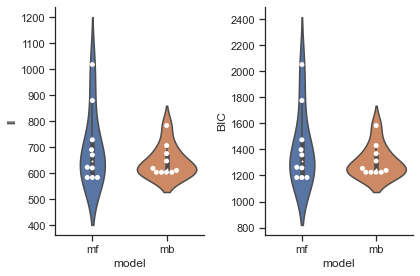

In [134]:
plt.subplot(1,2,1)
sns.violinplot(x="model", y="ll", data=fit_df, whis=np.inf)
sns.swarmplot(x="model", y="ll", data=fit_df, color='white')

plt.subplot(1,2,2)
sns.violinplot(x="model", y="BIC", data=fit_df, whis=np.inf)
sns.swarmplot(x="model", y="BIC", data=fit_df, color='white')

plt.tight_layout()
plt.show()

In [135]:
#deterimine best fit:
#included above.

**c4.** Use Bayesian Information Criterion (BIC) to compare which is the best fitting model for each subject. Compute the BIC using the formula: 

BIC = -2 * log-likelihood + ln(trials) *  # parameters

where $ln()$ is the natural logarithm. BIC is defined here on the deviance scale, which means that lower values are better. Which model fit each subject’s behavior best?

<AxesSubplot:xlabel='run', ylabel='BIC'>

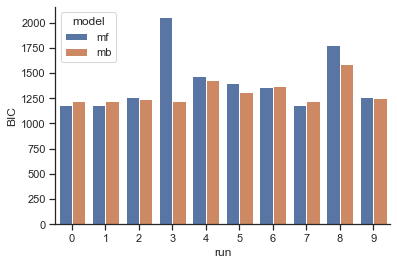

In [136]:
sns.barplot(x="run", y='BIC', hue='model',data=fit_df)

In [137]:
mf_gt_mb = np.array(fit_df[fit_df.model=='mf']['BIC']) > np.array(fit_df[fit_df.model=='mb']['BIC'])

print('Model free fits better in {}% of runs'.format(np.sum(mf_gt_mb)*10))
print('Model base fits better in {}% of runs'.format((10-np.sum(mf_gt_mb))*10))



Model free fits better in 60% of runs
Model base fits better in 40% of runs


>**Answer:** None of these models strictly fits better. The Model-free is performing marginally better.

### PART II – Cliff walking

Consider the grid world shown below. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked “The Cliff.” Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start.

<img src="cliff.png" width="500">  

Two paths are marked: an optimal path which incurs the least costs on the way to the goal, and a roundabout (but safe) path that walks farthest from the cliff. 

**1.** Which algorithm, SARSA or $Q$-learning, would learn either path, and why? 

>**Answer:** The main difference is that Q learning is an off-policy method, whereas SARSA is an on-policy method. 

> Off policy methods are more 'optimistic' in the sense that they use a greedy (optimal) next step - i.e., Q learning will result in the optimal (yet more risky path). 

> On policy methods have a more conservative value estimation since it considers the actual outcomes (one of which is the worst outcome of falling off the cliff). i.e., SARSA will learn the safer path.


**2.** When behaving according to softmax of the learned $Q$ values, which path would an agent prefer? (think about the parameter $β$ and the stability of the environment) 

>**Answer:** 



> The inverse temperature parameter, $\beta$, reflects the sensitivity of the choice kernel to the difference in values. Another way to look at it is how much stochasticity there is in the choice. Low $\beta$, let us say 0, will collapse the value estimate to a completely random choice (see below, in a two actions example, a $\beta=0$ results in both values =.5. On the other end, a high beta will separate the value into more and more extreme differences, resulting in a deterministic choice of the highest value option. A high $\beta$ agent will prefer the optimal path since there is a low probability of choosing a suboptimal action. A low $\beta$  agent will prefer the safer path since it may take some random actions.

> The environment stability is reflected in the transition probabilities - a stable environment will deterministically transition between states where a dynamic environment will include stochasticity. Similar to above, randomness calls for safety - thus, an agent would prefer the optimal path in a stable environment and the safer path in a stochastic one.



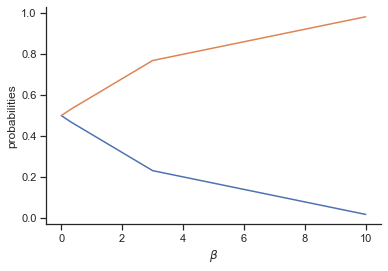

In [138]:
probs = np.array([.3,.7])

plt.plot([0,.3, 3, 10],
         [softmax(0*probs),
         softmax(.3*probs),
          softmax(3*probs),
          softmax(10*probs)])

plt.xlabel(r'$\beta$')
plt.ylabel('probabilities')

plt.show()

**3.** Can you suggest why on-policy methods might be superior for learning real-world motor behavior?

>**Answer:** On-policy methods are helpful for exploration, i.e., taking sub-optimal decisions allowing for learning new values in the environment. Motor skills involve flexible operations rather than hard-coded optimality. That also means it is better for responding to changes in the environment or unexpected obstacles - which makes sense in a motor task.
